# Modelamiento v2 - EMA (2018 - 2025) con variable 'temp2m" (Multi-step Forecasting)

#### **Estrategia de Pronóstico Multi-Horizonte (6h y 12h)**

Para generar alertas tempranas que permitan la planificación agrícola (´p. ej. activar riego o cubrir cultivos antes de la noche), extendemos el horizonte de predicción más allá de la siguiente hora ($t+1$).

**Metodología: Pronóstico Directo (Direct Multi-step Forecasting)**

A diferencia del enfoque recursivo (usar la predicción de $t+1$ para predecir $t+2$), que puede acumular errores exponencialmente, utilizamos una estrategia más directa. 
Entrenamos modelos independientes y especializados para cada horizonte temporal.

**Esquema del Flujo de Datos**

El objetivo es mapear las condiciones conocidas en el tiempo $t$ (Inputs) directamente con la temperatura futura en $t+h$ **(Target).**

TIEMPO (t)       |  INPUTS (Lo que sabemos)      |  TARGET (Lo que queremos saber)
-----------------|-------------------------------|--------------------------------
Actual (t)       |  Temp(t), Humedad(t)...       |  --> Temp(t+6)   (Modelo A)
Actual (t)       |  Temp(t), Humedad(t)...       |  --> Temp(t+12)  (Modelo B)

**Ingeniería de Características (Lags y Shifts)**

Para que el modelo entienda la dinámica temporal, construimos el dataset desplazando la variable objetivo hacia el pasado **("Shifting").**
Definimos matemáticamente el problema de regresión para un horizonte $h$:

$$\hat{y}_{t+h} = f_h(X_t, X_{t-1}, ..., X_{t-d})$$

**Donde:**

$\hat{y}_{t+h}$: Temperatura pronosticada a $h$ horas en el futuro.

$X_t$: Variables meteorológicas actuales (Radiación, Viento, etc.).

$X_{t-d}$: Variables con retardo (Lags) para capturar inercia y tendencias.

**Implementación en Código:**

**Feature (Lag):** df_multi_lag['lag_6'] = df_multi_lag['temp'].shift(6) $\rightarrow$ Trae el valor de hace 6 horas a la fila actual.

**Target (Shift Negativo):** df_multi_lag['target_12'] = df_multi_lag['temp'].shift(-12) $\rightarrow$ Trae el valor futuro (dentro de 12h) a la fila actual para entrenamiento.

**Nota:** Al generar estos desplazamientos, se pierden las primeras $d$ filas (falta de historia) y las últimas $h$ filas (falta de futuro conocido), las cuales se eliminan en la fase de limpieza.

## 1. Random Forest Regressor con Lag Temporal extendido y Multi-step Forecasting

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix

In [5]:
# 1. CARGA DE DATOS
df_multi_lag = pd.read_csv('../../data/processed/df_model_v2.csv', index_col=0, parse_dates=True)

## 2. Ingeniería de Características para Multi-Horizonte

In [6]:
# Necesitamos contexto para predecir a 6 y 12 horas.

# A. Tendencias (Rolling Statistics)
# IMPORTANTE: Saber si la temperatura ha estado bajando en las últimas 3 o 6 horas
df_multi_lag['roll_mean_3h'] = df_multi_lag['temp2m'].rolling(window=3).mean()
df_multi_lag['roll_std_6h']  = df_multi_lag['temp2m'].rolling(window=6).std()

# B. Lags (Pasado conocido)
df_multi_lag['temp2m_lag1'] = df_multi_lag['temp2m'].shift(1) # Estado inmediato anterior
df_multi_lag['temp2m_lag6'] = df_multi_lag['temp2m'].shift(6) # Estado hace 6 horas (ciclo diurno)

# C. Targets (Futuro a predecir - Shift Negativo)
df_multi_lag['target_h6']  = df_multi_lag['temp2m'].shift(-6)  # Temperatura dentro de 6 horas
df_multi_lag['target_h12'] = df_multi_lag['temp2m'].shift(-12) # Temperatura dentro de 12 horas

In [7]:
# Eliminamos los NaN generados por el rolling (inicio) y los targets (final)
df_model = df_multi_lag.dropna().copy()

print(f"Dataset procesado para horizontes extendidos: {df_model.shape}")

Dataset procesado para horizontes extendidos: (39181, 16)


## 3. Entrenamiento y Evaluación

In [8]:
horizontes = [6, 12]
modelos_dict = {}
metricas_resumen = []

# Variables predictoras (Inputs disponibles en tiempo 't')
features = ['temp2m', 'temp2m_lag1', 'temp2m_lag6', 'roll_mean_3h', 'roll_std_6h', 
            'radinf', 'HR', 'press', 'vel', 'dir_sin', 'dir_cos']

print(f"\nVariables predictoras usadas: {features}")


Variables predictoras usadas: ['temp2m', 'temp2m_lag1', 'temp2m_lag6', 'roll_mean_3h', 'roll_std_6h', 'radinf', 'HR', 'press', 'vel', 'dir_sin', 'dir_cos']


In [9]:
for h in horizontes:
    target_col = f'target_h{h}'
    
    print(f"\n{'='*50}")
    print(f" PROCESANDO HORIZONTE: +{h} HORAS")
    print(f"{'='*50}")
    
    # 1. DEFINICIÓN X e y
    X = df_model[features]
    y = df_model[target_col]
    
    # 2. SPLIT ORDENADO (Time Series Split)
    # 80% Train, 20% Test (Futuro)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # 3. ESCALADO
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 4. ENTRENAMIENTO (RF Regressor)
    print(f"Entrenando Random Forest para t+{h}...")
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
    rf.fit(X_train_scaled, y_train)
    modelos_dict[f'h{h}'] = rf
    
    # 5. PREDICCIÓN
    y_pred = rf.predict(X_test_scaled)
    
    # 6. EVALUACIÓN DE REGRESIÓN
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n--- Métricas Regresión (H+{h}) ---")
    print(f"MAE: {mae:.4f} °C")
    print(f"R²:  {r2:.4f}")
    
    # 7. ENFOQUE DE CLASIFICACIÓN (Evaluación de Alerta)
    # Convertimos la predicción numérica a binaria: ¿Habrá helada?
    UMBRAL = 0.0
    y_test_bin = (y_test <= UMBRAL).astype(int)
    y_pred_bin = (y_pred <= UMBRAL).astype(int)
    
    # Reporte
    print(f"\n--- Capacidad de Detección de Heladas (H+{h}) ---")
    print(classification_report(y_test_bin, y_pred_bin, target_names=['Normal', 'Helada']))


 PROCESANDO HORIZONTE: +6 HORAS
Entrenando Random Forest para t+6...

--- Métricas Regresión (H+6) ---
MAE: 1.6974 °C
R²:  0.6179

--- Capacidad de Detección de Heladas (H+6) ---
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      7601
      Helada       0.89      0.50      0.64       236

    accuracy                           0.98      7837
   macro avg       0.94      0.75      0.81      7837
weighted avg       0.98      0.98      0.98      7837


 PROCESANDO HORIZONTE: +12 HORAS
Entrenando Random Forest para t+12...

--- Métricas Regresión (H+12) ---
MAE: 1.5030 °C
R²:  0.7213

--- Capacidad de Detección de Heladas (H+12) ---
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99      7601
      Helada       0.88      0.65      0.75       236

    accuracy                           0.99      7837
   macro avg       0.93      0.82      0.87      7837
weighted avg       0.99      0.99    

In [10]:
# Extraer Recall específico de Helada
cm = confusion_matrix(y_test_bin, y_pred_bin)
if cm.shape == (2, 2):
    recall_helada = cm[1, 1] / (cm[1, 0] + cm[1, 1])
else:
    recall_helada = 0
    
metricas_resumen.append({'Horizonte': h, 'MAE': mae, 'R2': r2, 'Recall_Helada': recall_helada})

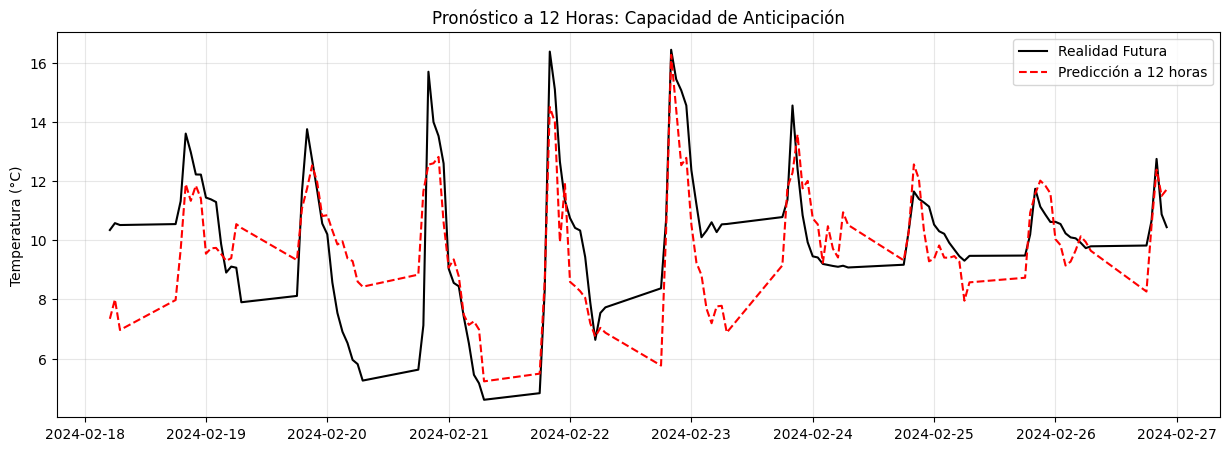


=== RESUMEN COMPARATIVO ===
   Horizonte       MAE        R2  Recall_Helada
0         12  1.502961  0.721294       0.652542


In [11]:
# 8. VISUALIZACIÓN (Zoom 5 días)
plt.figure(figsize=(15, 5))
plt.plot(y_test.index[:120], y_test.iloc[:120], label='Realidad Futura', color='black')
plt.plot(y_test.index[:120], y_pred[:120], label=f'Predicción a {h} horas', color='red', linestyle='--')
plt.title(f"Pronóstico a {h} Horas: Capacidad de Anticipación")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# RESUMEN FINAL
print("\n=== RESUMEN COMPARATIVO ===")
print(pd.DataFrame(metricas_resumen))